In [1]:
import pandas as pd
import numpy as np
import datajoint as dj
dj.config['database.host'] = '10.86.1.219'
dj.config['database.user'] = 'root'
dj.config['database.password'] = 'retina'
dj.config["enable_python_native_blobs"] = True # Only for testing in dj0.12 (https://github.com/datajoint/datajoint-python#python-native-blobs)

%env DJ_SUPPORT_FILEPATH_MANAGEMENT=TRUE
import os
os.chdir('..')
import main
drive_path = r"Z:\VEIDB/"
data_path = r"X:\Data"
# data_path =r"V:\Data/"
# data_path =r"W:\Data/"

ft = main.load(drive_path, data_path)

import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style('dark')

env: DJ_SUPPORT_FILEPATH_MANAGEMENT=TRUE
Connecting root@10.86.1.219:3306


In [2]:
# Import local Neuron project
import sys
module_paths = [os.path.abspath(r'C:\Users\bramn\Documents\CodingProjects'),
                os.path.abspath(r'C:\Users\bramn\Documents\CodingProjects\Neuron'),
                os.path.abspath(r'C:\Users\bramn\Documents\CodingProjects\Neuron\datatypes'),
                os.path.abspath(r'C:\Users\bramn\Documents\CodingProjects\Neuron\stages'),
                os.path.abspath(r'C:\Users\bramn\Documents\CodingProjects\Neuron\visualization')]
for module_path in module_paths:
    if module_path not in sys.path:
        sys.path.append(module_path)

import Neuron
import Neuron.datatypes.block
import Neuron.stages

In [3]:
exp_table = ft.Experiment()
sess_table = ft.Session()
mouse_table = ft.Mouse()
subsess_table = ft.Subsession()
raw_table = ft.ephys_tables.EphysRaw()
subsess_events_table = ft.event_tables.SubsessionEvents()
subsess_spikes_table = ft.ephys_tables.SubsessionSpikes()
trial_events_table = ft.event_tables.TrialEvents()

sorted_table = ft.ephys_tables.SpikeSorted()
ball_table = ft.behavior_tables.BallReadout()

In [4]:
figures_folder = os.path.join(r"C:\Users\bramn\Documents\CodingProjects\DatajointVEIDB\images\decoding")
if not os.path.isdir(figures_folder):
    os.mkdir(figures_folder)

## Responses for EXPA stimulus, all neurons

In [5]:
from Neuron.datatypes.block import Block
# import Neuron.stages as stages
from Neuron.stages import stage
from Neuron.stages.pipeline import Pipeline
from Neuron.stages.firing_rate_estimation import FiringRateEstimation
from Neuron.stages.downsampling import Downsampling
from Neuron.stages.PCA import PCA
from Neuron.stages.standardization import Standardization
from Neuron.stages.smoothing import Smoothing
from Neuron.visualization import spikes
from Neuron.utils import PeakDetection

In [6]:
sessions = [('01231', '20200327a'), ('01232', '20200328a'), ('01261', '20200327f'), ('01247', '20200328e')]
sessions_sSC_depths = [2250, 2450, 2550, 3100]

stims_vis = ['EXPA', 'DIMM', 'EXPW', 'CHPE']

In [27]:
def get_neural(subsess_key, data_type=None, hz=40, sSC_depth=0):
    unit_info, units = (subsess_spikes_table & subsess_key).fetch1('cluster_info', 'clusters')
    block = Block(units_dict=units, unit_info=unit_info).annot_slice(annot='good')
    block.remap_depth(center=sSC_depth, reverse=False)
    # Convert to firing rates
    line = Pipeline()
    line.add_stage(FiringRateEstimation(fr_type='counts'), binsize=30*(1000/hz), sampling_period=1000/hz) # 30*25 ==> hz=40
#     line.add_stage(Downsampling(ds_type='standard'), sz=40)
    firing_rates = line.execute(block.get_view('spikes'), meta=None)[-1]  
    block.add_view('instantaneous', firing_rates, hz=hz) # time axis...
    return block
    
def split_presentations(subsess_key, block, before=1000, after=1000):
    # Split by stim presentations
    block.set_view('counts')
    stim_blocks = []
    trial_starts, trial_ends = (subsess_events_table & subsess_key).fetch1('trials_starts', 'trials_ends')
    for start, end in zip(trial_starts, trial_ends):
        stim_blocks.append(block.time_slice(start/30-before, start/30+after))
    return stim_blocks

In [28]:
experiment_ids, session_ids, subsess_ids = (subsess_events_table * sorted_table & {'subsession_id': 'EXPA_0002'}).fetch('experiment_id', 'session_id', 'subsession_id')


In [29]:
experiment_ids

array(['01231', '01232', '01233', '01247', '01261'], dtype=object)

In [456]:
def get_subsession_data(subsess_key, sSC_depth):
    """ Retrieves a list of stimtype, neural activity, behavior tuples with all presentations in the subsession. """    
    subsess_block = get_neural(subsess_key=subsess_key, hz=40, sSC_depth=sSC_depth)
    subsess_pres_blocks = split_presentations(subsess_key, subsess_block, before=int(1000*2), after=1000*3)
    return subsess_pres_blocks

# trials_pres_neural = []
# for exp, sess, subsess in zip(experiment_ids, session_ids, subsess_ids):
#     print({'experiment_id': exp, 'session_id': sess, 'subsession_id': subsess})
#     subsess_key = {'experiment_id': exp, 'session_id': sess, 'subsession_id': subsess}
#     trial_pres_neural = get_subsession_data(subsess_key)
#     trials_pres_neural.append(trial_pres_neural)
    
trials_pres_neural = []
for (exp, sess), sSC_depth in zip(sessions, sessions_sSC_depths):
    print({'experiment_id': exp, 'session_id': sess, 'subsession_id': 'DIMM_0004'})
    subsess_key = {'experiment_id': exp, 'session_id': sess, 'subsession_id': 'DIMM_0004'}
    trial_pres_neural = get_subsession_data(subsess_key, sSC_depth=sSC_depth)
    trials_pres_neural.append(trial_pres_neural)


{'experiment_id': '01231', 'session_id': '20200327a', 'subsession_id': 'DIMM_0004'}
{'experiment_id': '01232', 'session_id': '20200328a', 'subsession_id': 'DIMM_0004'}
{'experiment_id': '01261', 'session_id': '20200327f', 'subsession_id': 'DIMM_0004'}
{'experiment_id': '01247', 'session_id': '20200328e', 'subsession_id': 'DIMM_0004'}


## Generate data matrix (trials x neurons x timepoints)

In [457]:
from scipy.signal import savgol_filter
from scipy import ndimage


In [458]:
X = []
for sess in trials_pres_neural:
    trials_list = []
    for trial_block in sess:
#         fig, ax = plt.subplots(1,1)
#         spikes.plot_raster(trial_block, ax=ax, visualize_depth=True)
#         plt.show()
        frs = trial_block.depth_slice(-350, 100).get_view('instantaneous')
#         frs = savgol_filter(frs, 11, 3, axis=1)
#         frs = savgol_filter(frs, 11, 3, axis=1)
        frs = ndimage.gaussian_filter1d(frs, sigma=5, axis=1)
        trials_list.append(frs)
    trials_list_npy = np.array(trials_list)
#     print(trials_list_npy.shape)
#     trials_list_npy = np.swapaxes(trials_list_npy, 0, 1)
#     trials_list_npy = trials_list_npy[(np.std(trials_list_npy, axis=(1,2)) > 0.05) & (np.max(trials_list_npy, axis=(1,2)) > 1)]
#     trials_list_npy = np.swapaxes(trials_list_npy, 0, 1)
    X.append(np.array(trials_list_npy))
X = np.concatenate(X, axis=1)

print(X.shape)

(10, 101, 200)


In [459]:
X.shape

(10, 101, 200)

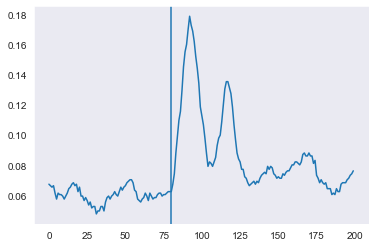

In [460]:
## Visualize responses

plt.plot(np.mean(X, (0, 1)))
plt.axvline(80)
plt.show()

c:\users\bramn\anaconda3\envs\datajoint\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\bramn\anaconda3\envs\datajoint\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


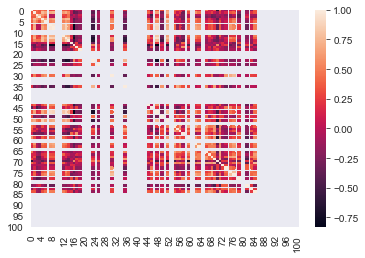

In [461]:
sb.heatmap(np.corrcoef(np.mean(X[:,:,80:], 0)))
plt.show()

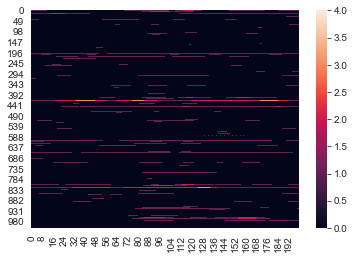

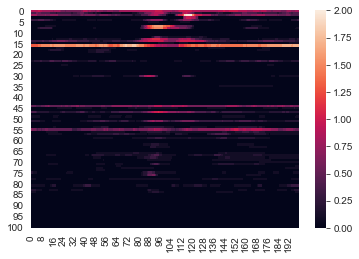

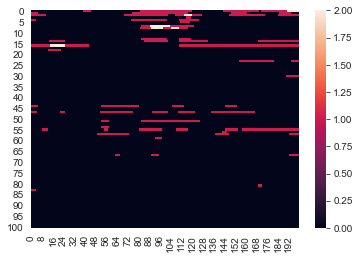

In [462]:
sb.heatmap(np.concatenate(X, 0))
plt.show()
sb.heatmap(np.mean(X, 0))
plt.show()
sb.heatmap(X[0])
plt.show()

In [463]:
np.concatenate(X, 0).shape

(1010, 200)

In [464]:
# Remove visually non-responsive neurons
# Load extra data
# Apply smoothing to spike counts

In [465]:
A = np.mean(X[:], axis=0)
print(A.shape)
A_base_mean = np.mean(A[:,:75], axis=1)
A_base_std = np.std(A[:,:75], axis=1)
# B = EXPW_fr[0]
# B_base_mean = EXPW_basefr_mean
# B_base_std = EXPW_basefr_std

visually_responsive_neurons = (np.mean(((A[:,80:].T-A_base_mean)/A_base_std).T, axis=1) > 0.2)

np.where(visually_responsive_neurons)[0].shape

(101, 200)


c:\users\bramn\anaconda3\envs\datajoint\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
c:\users\bramn\anaconda3\envs\datajoint\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
c:\users\bramn\anaconda3\envs\datajoint\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


(26,)

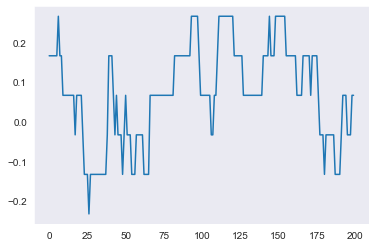

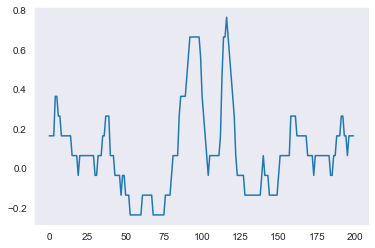

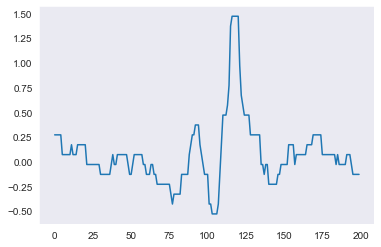

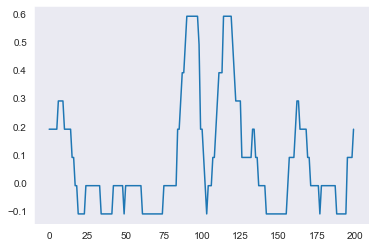

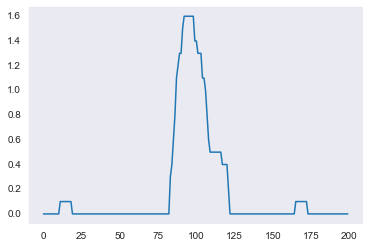

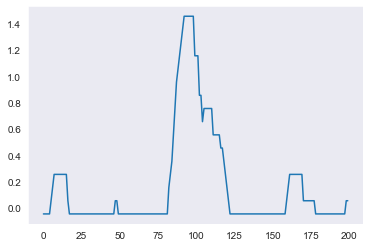

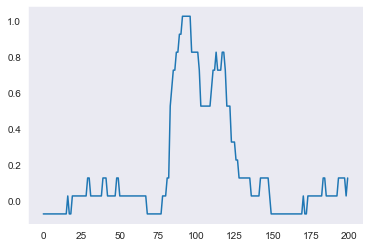

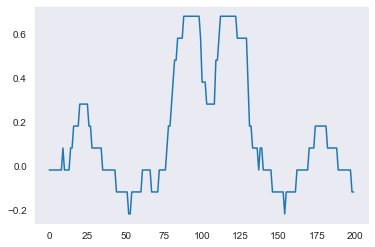

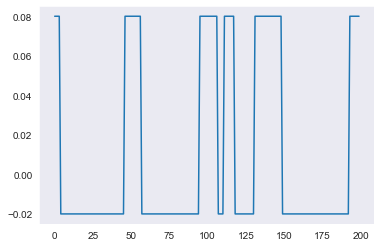

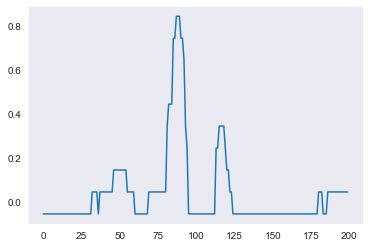

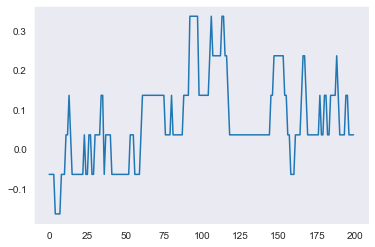

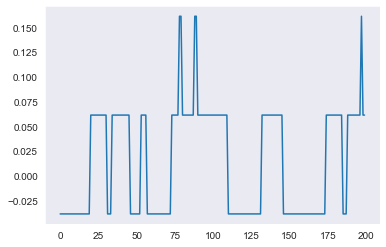

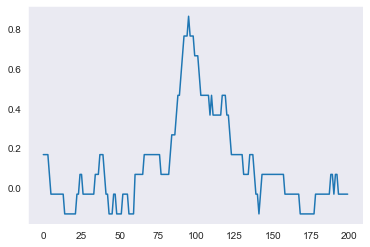

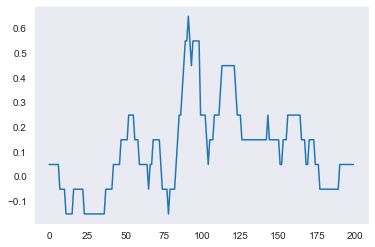

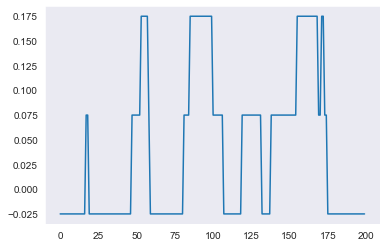

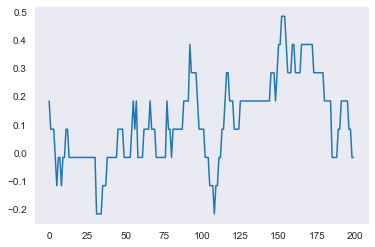

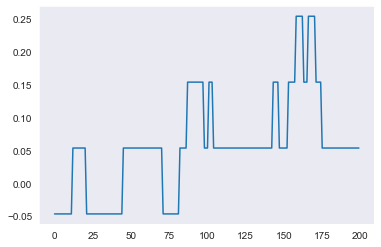

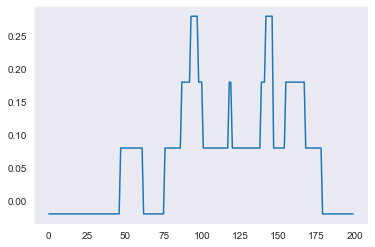

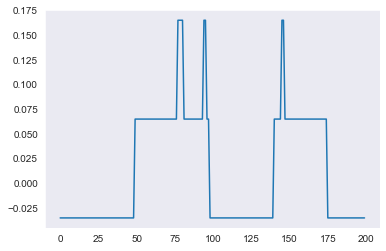

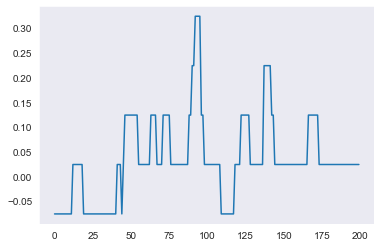

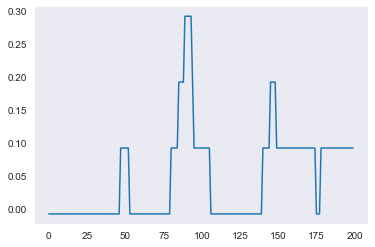

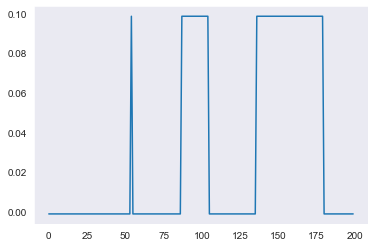

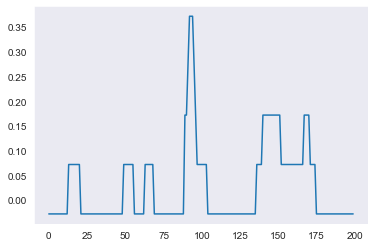

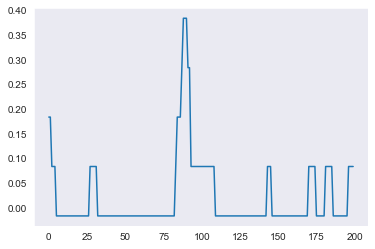

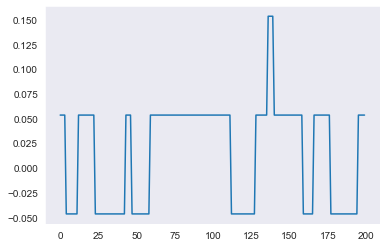

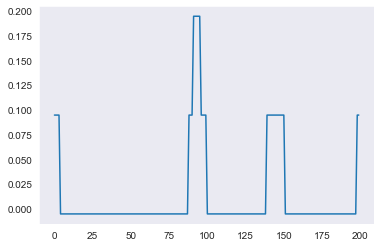

In [466]:
# X_visually_responsive = ((A[visually_responsive_neurons].T-A_base_mean[visually_responsive_neurons])/A_base_std[visually_responsive_neurons]).T
X_visually_responsive = ((A[visually_responsive_neurons].T-A_base_mean[visually_responsive_neurons])).T


for trace in (A[visually_responsive_neurons].T-A_base_mean[visually_responsive_neurons]).T:
    plt.plot(trace)
    plt.show()

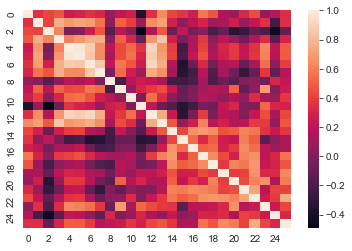

In [467]:
corrcoefs = np.corrcoef(X_visually_responsive[:,80:])
sb.heatmap(corrcoefs)
plt.show()

In [473]:
import umap
from sklearn.mixture import GaussianMixture

fit = umap.UMAP(n_neighbors=3, min_dist=0.8, n_components=2, metric='euclidean')
# u = fit.fit_transform(corrcoefs) # X_visually_responsive[:,80:]
u = fit.fit_transform(X_visually_responsive[:,80:160]) # X_visually_responsive[:,80:]

Text(0.5, 1.0, 'UMAP embedding of random colours')

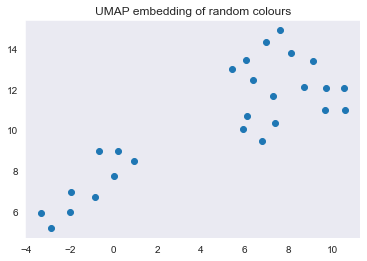

In [474]:
plt.scatter(u[:,0], u[:,1])
plt.title('UMAP embedding of random colours')

In [475]:
gm = GaussianMixture(n_components=3, random_state=0)
gm.fit(u) 

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

Text(0.5, 1.0, 'UMAP embedding of random colours')

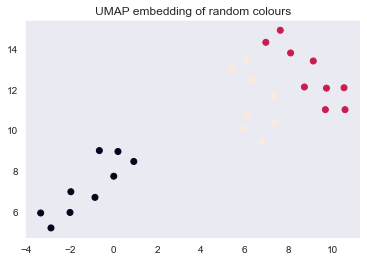

In [476]:
labels = gm.predict(u)
plt.scatter(u[:,0], u[:,1], c=labels)
plt.title('UMAP embedding of random colours')

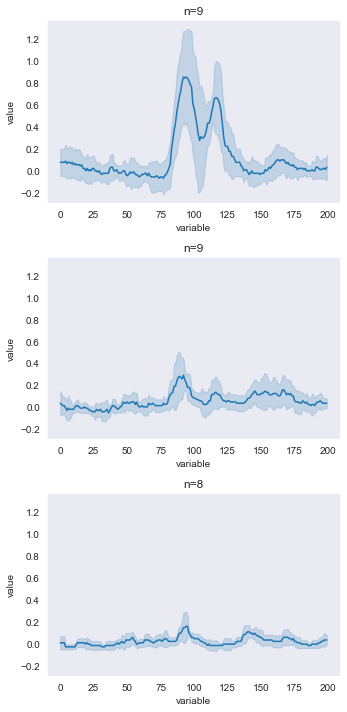

In [477]:
fig, axs = plt.subplots(len(np.unique(labels)), 1, sharey=True, figsize=(5, 10))
for i, label in enumerate(np.unique(labels)):
    df = pd.DataFrame(X_visually_responsive[labels==label]).melt()
    sb.lineplot(x="variable", y="value", data=df, estimator='mean', ci='sd', ax=axs[i])
    axs[i].set_title(f"n={len(X_visually_responsive[labels==label])}")
#     axs.plot(X_visually_responsive[labels==label].T)
#     plt.show()
plt.tight_layout()
plt.show()